In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=512, shuffle=False)

Using device: cuda


In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x, return_embedding=False):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        if return_embedding:
            return x  # return the 20-dim feature representation
        x = self.fc3(x)
        return x

model = MLP().to(device)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

print("\nTraining MLP on full MNIST dataset...")
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader):.4f}")



Training MLP on full MNIST dataset...
Epoch [1/10] - Loss: 0.8179
Epoch [2/10] - Loss: 0.3475
Epoch [3/10] - Loss: 0.3012
Epoch [4/10] - Loss: 0.2757
Epoch [5/10] - Loss: 0.2544
Epoch [6/10] - Loss: 0.2368
Epoch [7/10] - Loss: 0.2202
Epoch [8/10] - Loss: 0.2070
Epoch [9/10] - Loss: 0.1925
Epoch [10/10] - Loss: 0.1783



MLP Results on MNIST:
Accuracy: 0.9439, F1-score: 0.9432


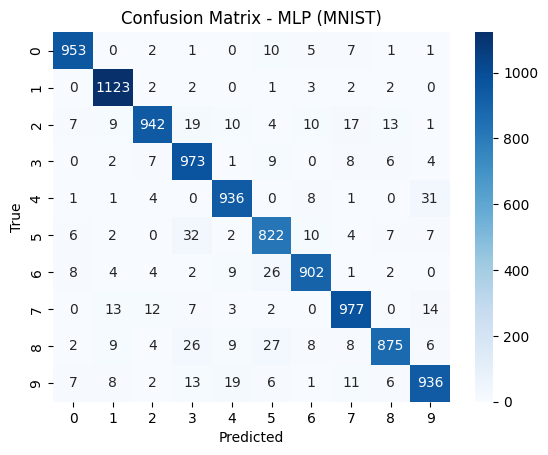

In [6]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

mlp_acc = accuracy_score(all_labels, all_preds)
mlp_f1 = f1_score(all_labels, all_preds, average='macro')

print("\nMLP Results on MNIST:")
print(f"Accuracy: {mlp_acc:.4f}, F1-score: {mlp_f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MLP (MNIST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [7]:
print("\nTraining baseline models (Random Forest & Logistic Regression)...")

X_train = mnist_train.data.view(-1, 28*28).numpy() / 255.0
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.view(-1, 28*28).numpy() / 255.0
y_test = mnist_test.targets.numpy()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')

# Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='macro')

print("\nRandom Forest:")
print(f"Accuracy: {rf_acc:.4f}, F1-score: {rf_f1:.4f}")
print("\nLogistic Regression:")
print(f"Accuracy: {lr_acc:.4f}, F1-score: {lr_f1:.4f}")


Training baseline models (Random Forest & Logistic Regression)...

Random Forest:
Accuracy: 0.9692, F1-score: 0.9690

Logistic Regression:
Accuracy: 0.9262, F1-score: 0.9251



Generating t-SNE visualizations...


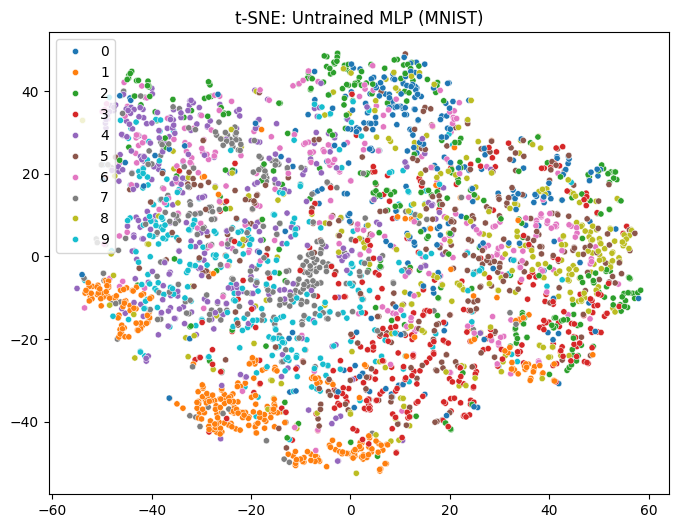

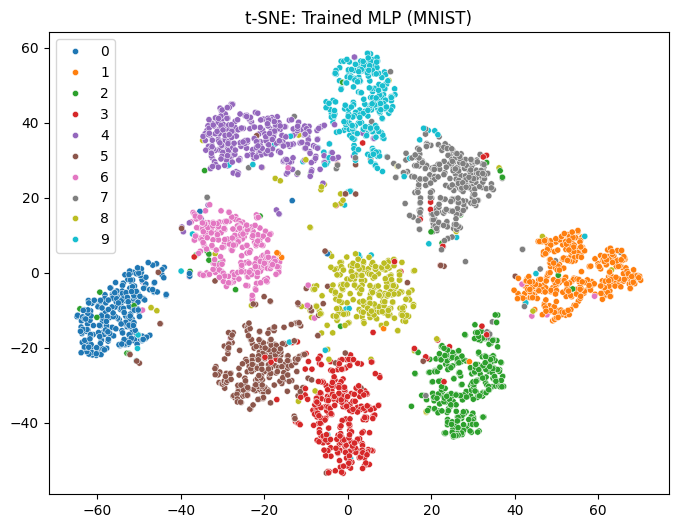

In [8]:

def get_embeddings(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = model(imgs, return_embedding=True).cpu().numpy()
            embeddings.append(feats)
            labels.append(lbls.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Untrained model
untrained_model = MLP().to(device)
untrained_embeds, untrained_labels = get_embeddings(untrained_model, test_loader)

# Trained model
trained_embeds, trained_labels = get_embeddings(model, test_loader)

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(embeddings[:3000])  # limit for speed
    lbl = labels[:3000]
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=lbl, palette='tab10', s=20, legend='full')
    plt.title(title)
    plt.show()

print("\nGenerating t-SNE visualizations...")
plot_tsne(untrained_embeds, untrained_labels, "t-SNE: Untrained MLP (MNIST)")
plot_tsne(trained_embeds, trained_labels, "t-SNE: Trained MLP (MNIST)")


Cross-domain Test (MNIST-trained MLP → Fashion-MNIST):
Accuracy: 0.1073 (not meaningful since classes differ)


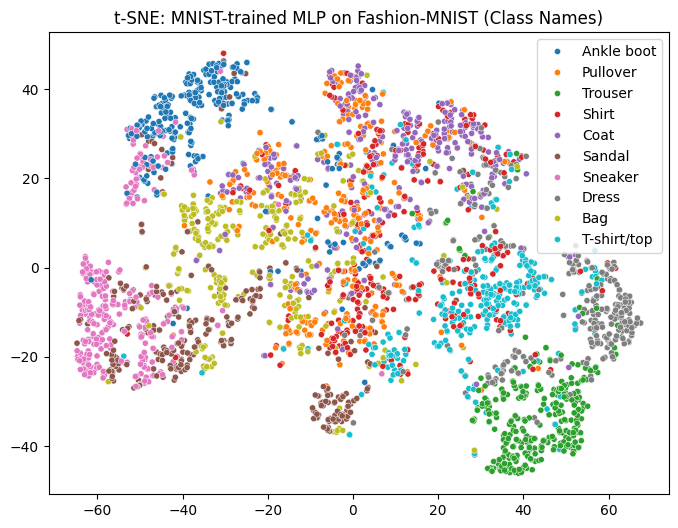


=== Summary ===
MLP (MNIST): Accuracy=0.9439, F1=0.9432
Random Forest: Accuracy=0.9692, F1=0.9690
Logistic Regression: Accuracy=0.9262, F1=0.9251
Cross-domain (Fashion-MNIST): Accuracy=0.1073

Observation: MLP significantly outperforms baselines on MNIST, but generalization to Fashion-MNIST is poor — embeddings differ clearly in t-SNE plots.


In [19]:
# Fashion-MNIST class names
fashion_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Create DataLoader for Fashion-MNIST
fashion_loader = DataLoader(fashion_test, batch_size=512, shuffle=False)
fashion_embeds, fashion_labels = get_embeddings(model, fashion_loader)

# Evaluate cross-domain performance
model.eval()
f_preds, f_labels = [], []
with torch.no_grad():
    for imgs, labels in fashion_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        f_preds.extend(preds.cpu().numpy())
        f_labels.extend(labels.cpu().numpy())

cross_acc = accuracy_score(f_labels, f_preds)
print("\nCross-domain Test (MNIST-trained MLP → Fashion-MNIST):")
print(f"Accuracy: {cross_acc:.4f} (not meaningful since classes differ)")

# Map numeric labels to class names for visualization
fashion_label_names = [fashion_classes[l] for l in fashion_labels]

# Plot t-SNE using class names instead of digits
plot_tsne(fashion_embeds, fashion_label_names, "t-SNE: MNIST-trained MLP on Fashion-MNIST (Class Names)")

# Summary
print("\n=== Summary ===")
print(f"MLP (MNIST): Accuracy={mlp_acc:.4f}, F1={mlp_f1:.4f}")
print(f"Random Forest: Accuracy={rf_acc:.4f}, F1={rf_f1:.4f}")
print(f"Logistic Regression: Accuracy={lr_acc:.4f}, F1={lr_f1:.4f}")
print("Cross-domain (Fashion-MNIST): Accuracy={:.4f}".format(cross_acc))
print("\nObservation: MLP significantly outperforms baselines on MNIST, but generalization to Fashion-MNIST is poor — embeddings differ clearly in t-SNE plots.")


In [11]:
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
epochs = 5

print("\nTraining Simple CNN on MNIST...")
for epoch in range(epochs):
    cnn_model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")



Training Simple CNN on MNIST...
Epoch [1/5] Loss: 0.4315
Epoch [2/5] Loss: 0.1347
Epoch [3/5] Loss: 0.0872
Epoch [4/5] Loss: 0.0659
Epoch [5/5] Loss: 0.0538


In [13]:
def evaluate_model(model, loader, name="Model"):
    model.eval()
    preds, labels = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            y_pred = torch.argmax(outputs, dim=1)
            preds.extend(y_pred.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    end = time.time()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    inf_time = end - start
    cm = confusion_matrix(labels, preds)
    return acc, f1, inf_time, cm


Simple CNN Results:
Accuracy: 0.9804, F1-score: 0.9802, Inference time: 1.96s


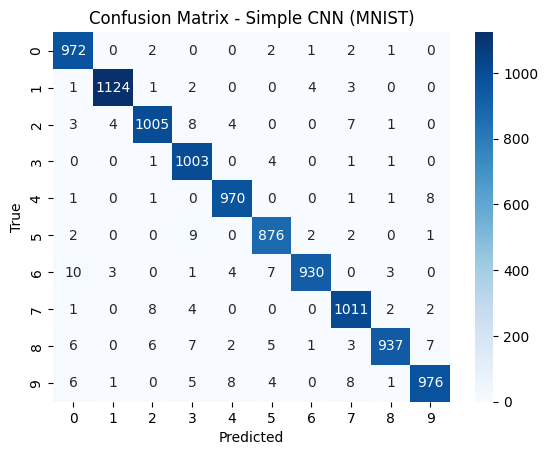

In [14]:
cnn_acc, cnn_f1, cnn_time, cnn_cm = evaluate_model(cnn_model, test_loader, "SimpleCNN")

print(f"\nSimple CNN Results:")
print(f"Accuracy: {cnn_acc:.4f}, F1-score: {cnn_f1:.4f}, Inference time: {cnn_time:.2f}s")

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Simple CNN (MNIST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
imagenet_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_large_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    imagenet_norm
])

transform_large_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    imagenet_norm
])

mnist_train_large = datasets.MNIST(root="./data", train=True, transform=transform_large_train)
mnist_test_large = datasets.MNIST(root="./data", train=False, transform=transform_large_test)

train_loader_large = DataLoader(mnist_train_large, batch_size=64, shuffle=True)
test_loader_large = DataLoader(mnist_test_large, batch_size=128, shuffle=False)


In [16]:
mobilenet = models.mobilenet_v2(pretrained=True)
for param in mobilenet.features.parameters():
    param.requires_grad = False
mobilenet.classifier[1] = nn.Linear(1280, 10)
mobilenet = mobilenet.to(device)

optimizer_m = optim.Adam(mobilenet.classifier.parameters(), lr=1e-3)
print("\nTraining MobileNetV2 on MNIST (transfer learning)...")

for epoch in range(3):
    mobilenet.train()
    total_loss = 0
    for imgs, labels in train_loader_large:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_m.zero_grad()
        outputs = mobilenet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_m.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/3] Loss: {total_loss/len(train_loader_large):.4f}")

mobilenet_acc, mobilenet_f1, mobilenet_time, mobilenet_cm = evaluate_model(mobilenet, test_loader_large, "MobileNetV2")



Training MobileNetV2 on MNIST (transfer learning)...
Epoch [1/3] Loss: 0.3820
Epoch [2/3] Loss: 0.2013
Epoch [3/3] Loss: 0.1778


In [17]:
efficientnet = models.efficientnet_b0(pretrained=True)
for param in efficientnet.features.parameters():
    param.requires_grad = False
efficientnet.classifier[1] = nn.Linear(1280, 10)
efficientnet = efficientnet.to(device)

optimizer_e = optim.Adam(efficientnet.classifier.parameters(), lr=1e-3)
print("\nTraining EfficientNet-B0 on MNIST (transfer learning)...")

for epoch in range(3):
    efficientnet.train()
    total_loss = 0
    for imgs, labels in train_loader_large:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_e.zero_grad()
        outputs = efficientnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_e.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/3] Loss: {total_loss/len(train_loader_large):.4f}")

efficient_acc, efficient_f1, efficient_time, efficient_cm = evaluate_model(efficientnet, test_loader_large, "EfficientNet-B0")


Training EfficientNet-B0 on MNIST (transfer learning)...
Epoch [1/3] Loss: 0.4719
Epoch [2/3] Loss: 0.2638
Epoch [3/3] Loss: 0.2336



=== Final Comparison Summary ===
          Model  Accuracy  F1-score  Trainable Params (M)  Inference Time (s)
     Simple CNN    0.9804  0.980242              0.804554            1.960770
    MobileNetV2    0.9604  0.959928              0.012810           28.105231
EfficientNet-B0    0.9585  0.958097              0.012810           31.183131


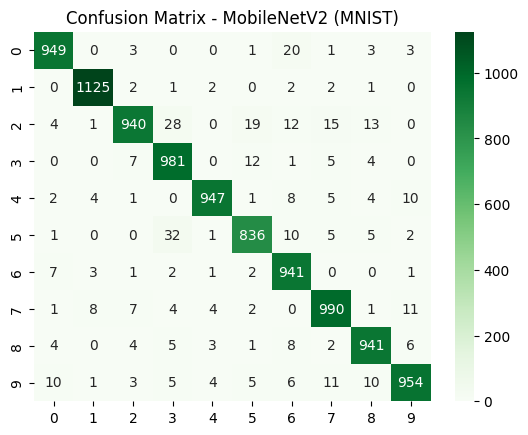

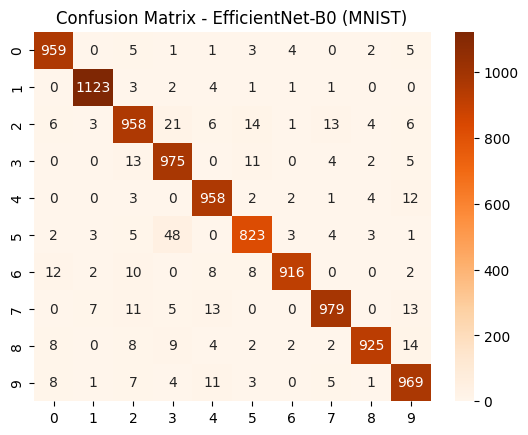

In [18]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cnn_params = count_params(cnn_model)
mobilenet_params = count_params(mobilenet)
efficient_params = count_params(efficientnet)


# Summary

summary = pd.DataFrame({
    "Model": ["Simple CNN", "MobileNetV2", "EfficientNet-B0"],
    "Accuracy": [cnn_acc, mobilenet_acc, efficient_acc],
    "F1-score": [cnn_f1, mobilenet_f1, efficient_f1],
    "Trainable Params (M)": [cnn_params/1e6, mobilenet_params/1e6, efficient_params/1e6],
    "Inference Time (s)": [cnn_time, mobilenet_time, efficient_time]
})

print("\n=== Final Comparison Summary ===")
print(summary.to_string(index=False))

sns.heatmap(mobilenet_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - MobileNetV2 (MNIST)")
plt.show()

sns.heatmap(efficient_cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - EfficientNet-B0 (MNIST)")
plt.show()